# LSTM

## Caricamento del dataframe

In [1]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn

import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from torch.utils.tensorboard import SummaryWriter

import os
import shutil
import glob

main_folder = "../data"

folder = "./runs/LSTM"

try:
    #shutil.rmtree(folder + "/Acc_train_val_train")
    #shutil.rmtree(folder + "/Acc_train_val_val")
    #shutil.rmtree(folder + "/Loss_train_val_train")
    #shutil.rmtree(folder + "/Loss_train_val_val")
    #os.rmdir(folder + "/Acc_train_val_train")
    #os.rmdir(folder + "/Acc_train_val_val")
    #os.rmdir(folder + "/Loss_train_val_train")
    #os.rmdir(folder + "/Loss_train_val_val")
    #shutil.rmtree(folder)
    #os.rmdir(folder)
    shutil.rmtree(folder, ignore_errors=True)
except:
    pass

try:
    os.mkdir(folder)
except:
    pass

writer = SummaryWriter(folder)

## Train - Validation - Test

In [2]:
class2idx = {
    "No_action": 0,
    "Prendi": 1,
    "Rilascia": 2,
    "Premi": 3
}

idx2class = {v: k for k, v in class2idx.items()}

In [3]:
def join_csv(folder_set, filename):
    csv:list = []

    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)

    columns:bool = True
    with open(filename, "w") as f:
        for fcsv in csv:
            with open(fcsv, "r") as fc:
                if columns:
                    f.writelines(fc.readlines())
                    columns = False
                fc.readline()
                f.writelines(fc.readlines())

In [4]:
def create_set(folder_set, filename) -> list:
    csv:list = []
    for file in glob.glob(folder_set + "/*.csv"):
        csv.append(file)
    columns:bool = True
    colname = []
    data = []
    target = []
    for fcsv in csv:
        data_video = []
        target_video = []
        with open(fcsv, "r") as fc:
            if columns:
                colname = [(name) for name in fc.readline().split(",")]
                colname[-1] = colname[-1][:-1]
                columns = False
            else:
                fc.readline()
            for row in fc.readlines():
              split_row = row.split(",")
              data_video.append(split_row[:-1])
              target_video.append(class2idx[split_row[-1][:-1]])
        data.append(np.array(data_video).astype(float))
        target.append(np.array(target_video).astype(int))
    return (np.array(data, dtype=object), np.array(target, dtype=object), colname)

In [5]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

train_array, train_label_array, colname = create_set(folder_set[0][0], folder_set[0][1])
test_array, test_label_array, colname = create_set(folder_set[1][0], folder_set[1][1])
val_array, val_label_array, colname = create_set(folder_set[2][0], folder_set[2][1])
#print(train_array.shape, train_label_array.shape, test_array.shape, test_label_array.shape, val_array.shape, val_label_array.shape, colname)
for elem, label in zip(train_array, train_label_array):
  print(elem.shape, label.shape)
  print(type(elem), type(label))

(1031, 156) (1031,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2367, 156) (2367,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2193, 156) (2193,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1245, 156) (1245,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2247, 156) (2247,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(563, 156) (563,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(3791, 156) (3791,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(971, 156) (971,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1361, 156) (1361,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1188, 156) (1188,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(819, 156) (819,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1164, 156) (1164,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1732, 156) (1732,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(486, 156) (486,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1516, 156) (1516,)
<class 'numpy.ndarray'> <class 'nump

In [6]:
folder_set = [[main_folder + "/train_set", main_folder + "/train.csv"], [main_folder + "/test_set", main_folder + "/test.csv"], [main_folder + "/val_set", main_folder + "/val.csv"]]

for f_set, filename in folder_set:
    join_csv(f_set, filename)
    
train = pd.read_csv(main_folder + "/train.csv")
test = pd.read_csv(main_folder + "/test.csv")
val = pd.read_csv(main_folder + "/val.csv")

train['TARGET'].replace(class2idx, inplace=True)
test['TARGET'].replace(class2idx, inplace=True)
val['TARGET'].replace(class2idx, inplace=True)

In [7]:
train.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
val.head()

,RIGHT_Palm_x,RIGHT_Palm_y,RIGHT_Palm_z,LEFT_Palm_x,LEFT_Palm_y,LEFT_Palm_z,RIGHT_ThumbTip_x,RIGHT_ThumbTip_y,RIGHT_ThumbTip_z,LEFT_ThumbTip_x,...,LEFT_PinkyMetacarpal_x,LEFT_PinkyMetacarpal_y,LEFT_PinkyMetacarpal_z,RIGHT_Wrist_x,RIGHT_Wrist_y,RIGHT_Wrist_z,LEFT_Wrist_x,LEFT_Wrist_y,LEFT_Wrist_z,TARGET
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
print(train.shape[0], test.shape[0], val.shape[0])

54886 16126 10453


In [11]:
def create_dataset(dataset, target, window_size = 2):
    dataX, dataY = [], []
    for i in range(len(dataset) - window_size):
        dataX.append(dataset[i:(i + window_size)])
        dataY.append(target[i:(i + window_size + 1)].values[0])
    return np.array(dataX), np.array(dataY)

Si separano le colonne delle features dall'etichetta.

In [12]:
train_label = train["TARGET"]
test_label = test["TARGET"]
val_label = val["TARGET"]

del train["TARGET"]
del test["TARGET"]
del val["TARGET"]

## Visualizzazione della distribuzione delle classi in Train, Val e Test

In [13]:
def get_class_distribution(obj):
    count_dict = {
        "No_action": 0,
        "Prendi": 0,
        "Rilascia": 0,
        "Premi": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['No_action'] += 1
        elif i == 1: 
            count_dict['Prendi'] += 1
        elif i == 2: 
            count_dict['Rilascia'] += 1
        elif i == 3: 
            count_dict['Premi'] += 1            
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

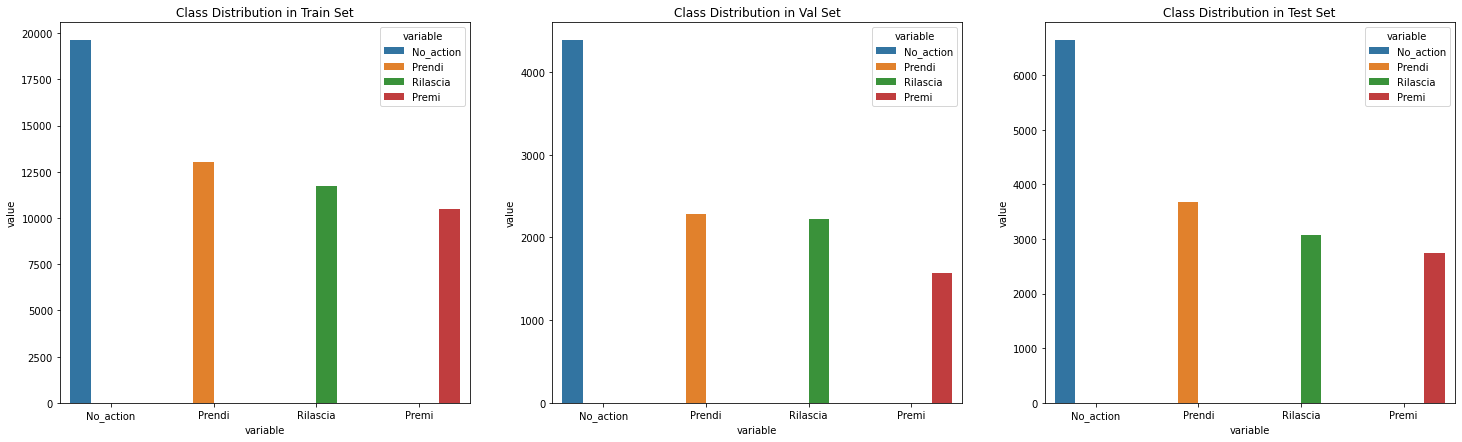

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_label)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [16]:
window_size = 1

In [17]:
train_X, train_Y = create_dataset(train, train_label, window_size)
train_dataset_w = ClassifierDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long())

test_X, test_Y = create_dataset(test, test_label, window_size)
test_dataset_w = ClassifierDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_Y).long())

val_X, val_Y = create_dataset(val, val_label, window_size)
val_dataset_w = ClassifierDataset(torch.from_numpy(val_X).float(), torch.from_numpy(val_Y).long())


#train_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(train_array, train_label_array)]

#test_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(test_array, test_label_array)]

#val_dataset = [(ClassifierDataset(torch.from_numpy(array).float(), torch.from_numpy(label).long())) for array, label in zip(val_array, val_label_array)]

In [18]:
def create_dataset(array, label, window):
    dataset = []
    for array, label in zip(train_array, train_label_array):
        l = array.shape[0]
        i = 0
        div_len_train = 0
        while l - i >= window:
            X_b = []
            y_b = []
            for _ in range(window):
                X_b.append(array[i])
                y_b.append(label[i])
                i += 1
            X_batch = torch.from_numpy(np.array(X_b).astype(float)).float()
            y_batch = torch.from_numpy(np.array(y_b).astype(int)).long()
            dataset.append(ClassifierDataset(X_batch, y_batch))
    return dataset

In [19]:
window = 60
train_dataset = create_dataset(train_array, train_label_array, window)
test_dataset = create_dataset(test_array, test_label_array, window)
val_dataset = create_dataset(val_array, val_label_array, window)

In [20]:
print(train_dataset[0].X_data.shape)
print(train_dataset[0].y_data.shape)
print(len(train_dataset))

torch.Size([60, 156])
torch.Size([60])
894


## Weighted Sampling

Poiché c'è uno squilibrio di classe, utilizziamo la suddivisione stratificata per creare i nostri set di train, convalida e test.

In [21]:
target_list = []

for _, t in train_dataset_w:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

Quindi, otteniamo il conteggio di tutte le classi nel nostro set di allenamento.  Usiamo il reciproco di ogni conteggio per ottenere il suo peso.  Ora che abbiamo calcolato i pesi per ogni classe, possiamo procedere.

In [22]:
class_count = [i for i in get_class_distribution(train_label).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 

print(class_weights)

tensor([5.1000e-05, 7.6664e-05, 8.5157e-05, 9.5320e-05])


WeightedRandomSampler prevede un peso per ogni campione.  Lo usiamo come segue.

In [23]:
class_weights_all = class_weights[target_list]

Infine, inizializziamo il nostro WeightedRandomSampler.  Lo chiameremo nel nostro dataloader in seguito.

In [24]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

## Parametri del modello

In [63]:
EPOCHS = 20
LEARNING_RATE = 0.4
NUM_FEATURES = 156
NUM_CLASSES = 4

## Rete Neurale LSTM

In [64]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=78, num_layers=1):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.layer_1 = nn.Linear(hidden_layer_size, 39)
        self.layer_2 = nn.Linear(39, 13)
        self.layer_3 = nn.Linear(13, 8)
        self.layer_out = nn.Linear(8, output_size) 
        
        self.tanh = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(39)
        self.batchnorm2 = nn.BatchNorm1d(13)
        self.batchnorm3 = nn.BatchNorm1d(8)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
        h, hn = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        
        h = self.layer_1(h.view(len(x), -1))
        h = self.batchnorm1(h)
        h = self.tanh(h)
        
        h = self.layer_2(h)
        h = self.batchnorm2(h)
        h = self.tanh(h)
        h = self.dropout(h)
        
        h = self.layer_3(h)
        h = self.batchnorm3(h)
        h = self.tanh(h)
        h = self.dropout(h)
        
        h = self.layer_out(h)
        
        return h, hn

In [65]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size=4, hidden_layer_size=78, num_layers=2):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_layer_size 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.regressor = nn.Linear(hidden_layer_size, output_size)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h0 = hidden[0]
            c0 = hidden [1]
        else:
            h0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
            c0 = torch.zeros(self.num_layers, 1, self.hidden_size).to(device)
        h, hn = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        h = self.regressor(h.view(len(x), -1))        
        return h, hn

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
device

device(type='cuda')

In [68]:
model = LSTM(input_size=NUM_FEATURES, output_size=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

print(model)

LSTM(
  (lstm): LSTM(156, 78, num_layers=2)
  (regressor): Linear(in_features=78, out_features=4, bias=True)
)


## Train the model

Prima di iniziare il nostro addestramento, definiamo una funzione per calcolare la precisione per epoca.

Questa funzione accetta y_pred e y_test come argomenti di input.  Quindi applichiamo log_softmax a y_pred ed estraiamo la classe che ha una probabilità maggiore.

Successivamente, confrontiamo le classi previste e le classi effettive per calcolare l'accuratezza.

In [69]:
def multi_acc(y_pred, y_true):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    return accuracy_score(y_true.tolist(), y_pred_tags.tolist()) * 100

In [70]:
def multi_f1(y_pred, y_true):
    _, y_pred_tags = torch.max(y_pred, dim = 1)
    return f1_score(y_true.tolist(), y_pred_tags.tolist(), average=None, zero_division=1, labels=[0,1,2,3])

Definiremo anche 2 dizionari che memorizzeranno l'accuratezza/epoca e la perdita/epoca sia per il treno che per i set di convalida.

In [71]:
accuracy_stats = {
    'train': [],
    "val": []
}

loss_stats = {
    'train': [],
    "val": []
}

f1_score_No_action = {
    'train': [],
    "val": []
}

f1_score_Prendi = {
    'train': [],
    "val": []
}

f1_score_Rilascia = {
    'train': [],
    "val": []
}

f1_score_Premi = {
    'train': [],
    "val": []
}

In [72]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    train_epoch_f1_No_action = 0
    train_epoch_f1_Prendi = 0
    train_epoch_f1_Rilascia = 0
    train_epoch_f1_Premi = 0
    
    model.train()

    hidden_train = None

    for train in train_dataset:
        X_train_batch, y_train_batch = train.X_data.to(device), train.y_data.to(device)
        optimizer.zero_grad()
        y_train_pred, hidden_train = model(X_train_batch, hidden_train)

        h0, c0 = hidden_train
        h0.detach_(), c0.detach_()
        hidden_train = (h0, c0)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        train_f1 = multi_f1(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        train_epoch_f1_No_action += train_f1[0].item()
        train_epoch_f1_Prendi += train_f1[1].item()
        train_epoch_f1_Rilascia += train_f1[2].item()
        train_epoch_f1_Premi += train_f1[3].item()
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        val_epoch_f1 = 0
        val_epoch_f1_No_action = 0
        val_epoch_f1_Prendi = 0
        val_epoch_f1_Rilascia = 0
        val_epoch_f1_Premi = 0
      
        #hidden_valid = (h0, c0)
        hidden_valid = None

        model.eval()
        for val in val_dataset:
            X_val_batch, y_val_batch = val.X_data.to(device), val.y_data.to(device)
            y_val_pred, _ = model(X_val_batch, hidden_valid)

            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            val_f1 = multi_f1(y_val_pred, y_val_batch)

            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            val_epoch_f1_No_action += val_f1[0].item()
            val_epoch_f1_Prendi += val_f1[1].item()
            val_epoch_f1_Rilascia += val_f1[2].item()
            val_epoch_f1_Premi += val_f1[3].item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_dataset))        
    loss_stats['val'].append(val_epoch_loss/len(val_dataset))
    accuracy_stats['train'].append(train_epoch_acc/len(train_dataset))
    accuracy_stats['val'].append(val_epoch_acc/len(val_dataset))
    f1_score_No_action['train'].append(train_epoch_f1_No_action/len(train_dataset))
    f1_score_No_action['val'].append(val_epoch_f1_No_action/len(val_dataset))
    f1_score_Prendi['train'].append(train_epoch_f1_Prendi/len(train_dataset))
    f1_score_Prendi['val'].append(val_epoch_f1_Prendi/len(val_dataset))
    f1_score_Rilascia['train'].append(train_epoch_f1_Rilascia/len(train_dataset))
    f1_score_Rilascia['val'].append(val_epoch_f1_Rilascia/len(val_dataset))
    f1_score_Premi['train'].append(train_epoch_f1_Premi/len(train_dataset))
    f1_score_Premi['val'].append(val_epoch_f1_Premi/len(val_dataset))
                              
    writer.add_scalars("Loss/train_val", {
        "train": train_epoch_loss/len(train_dataset),
        "val": val_epoch_loss/len(val_dataset),
    }, e)
    writer.add_scalars("Acc/train_val", {
        "train": train_epoch_acc/len(train_dataset),
        "val": val_epoch_acc/len(val_dataset),
    }, e)
    writer.add_scalars("F1-No_action/train_val", {
        "train": train_epoch_f1_No_action/len(train_dataset),
        "val": val_epoch_f1_No_action/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Prendi/train_val", {
        "train": train_epoch_f1_Prendi/len(train_dataset),
        "val": val_epoch_f1_Prendi/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Rilascia/train_val", {
        "train": train_epoch_f1_Rilascia/len(train_dataset),
        "val": val_epoch_f1_Rilascia/len(val_dataset),
    }, e)
    writer.add_scalars("F1-Premi/train_val", {
        "train": train_epoch_f1_Premi/len(train_dataset),
        "val": val_epoch_f1_Premi/len(val_dataset),
    }, e)
    writer.flush()
    print(f'Epoch {e+0:03}:\
          | Train Loss: {train_epoch_loss/len(train_dataset):.5f}\
          | Val Loss: {val_epoch_loss/len(val_dataset):.5f}\
          | Train Acc: {train_epoch_acc/len(train_dataset):.3f}\
          | Val Acc: {val_epoch_acc/len(val_dataset):.3f}\
          | Train F1-No_action: {train_epoch_f1_No_action/len(train_dataset):.5f}\
          | Val F1-No_action: {val_epoch_f1_No_action/len(val_dataset):.5f}\
          | Train F1-Prendi: {train_epoch_f1_Prendi/len(train_dataset):.5f}\
          | Val F1-Prendi: {val_epoch_f1_Prendi/len(val_dataset):.5f}\
          | Train F1-Rilascia: {train_epoch_f1_Rilascia/len(train_dataset):.5f}\
          | Val F1-Rilascia: {val_epoch_f1_Rilascia/len(val_dataset):.5f}\
          | Train F1-Premi: {train_epoch_f1_Premi/len(train_dataset):.5f}\
          | Val F1-Premi: {val_epoch_f1_Premi/len(val_dataset):.5f}')
writer.close()
print("Done.")

Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001:          | Train Loss: 1.03281          | Val Loss: 0.98854          | Train Acc: 47.696          | Val Acc: 50.610          | Train F1-No_action: 0.78736          | Val F1-No_action: 0.84322          | Train F1-Prendi: 0.48630          | Val F1-Prendi: 0.56264          | Train F1-Rilascia: 0.48365          | Val F1-Rilascia: 0.54131          | Train F1-Premi: 0.58823          | Val F1-Premi: 0.32458
Epoch 002:          | Train Loss: 0.98215          | Val Loss: 0.97989          | Train Acc: 49.213          | Val Acc: 51.005          | Train F1-No_action: 0.80773          | Val F1-No_action: 0.84812          | Train F1-Prendi: 0.48811          | Val F1-Prendi: 0.56264          | Train F1-Rilascia: 0.47858          | Val F1-Rilascia: 0.54262          | Train F1-Premi: 0.57749          | Val F1-Premi: 0.35906
Epoch 003:          | Train Loss: 0.97576          | Val Loss: 0.97363          | Train Acc: 49.674          | Val Acc: 51.288          | Train F1-No_action: 0.81527     

## Visualizzazione Loss e Accuracy

Per tracciare i grafici delle linee di perdita e accuratezza, creiamo nuovamente un dataframe dai dizionari precision_stats e loss_stats.

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

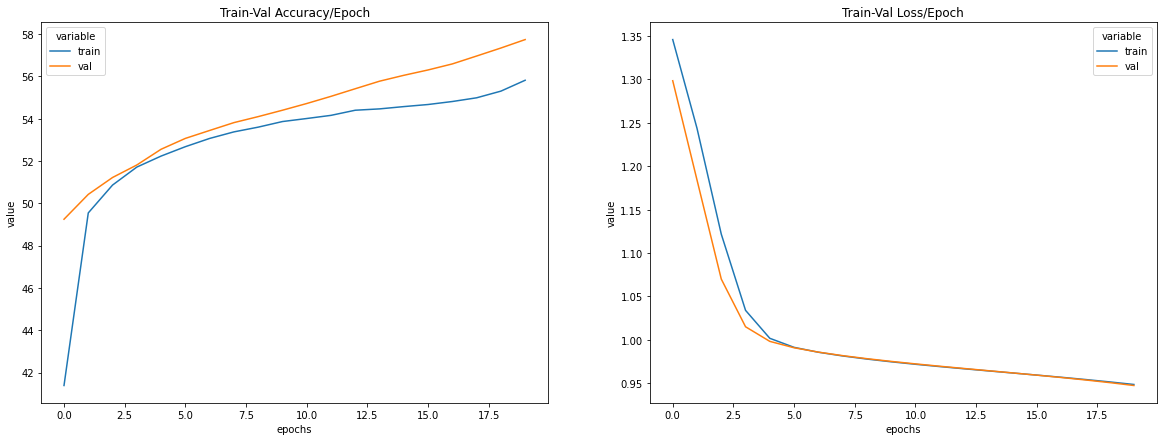

In [54]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_No_action = pd.DataFrame.from_dict(f1_score_No_action).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Prendi = pd.DataFrame.from_dict(f1_score_Prendi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Rilascia = pd.DataFrame.from_dict(f1_score_Rilascia).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_f1_Premi = pd.DataFrame.from_dict(f1_score_Premi).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Prendi/Epoch')

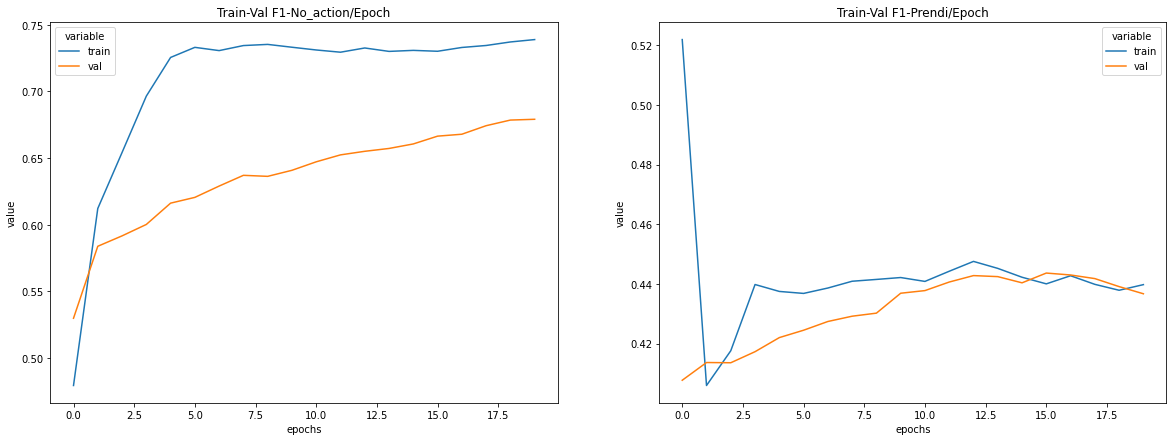

In [55]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_No_action, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-No_action/Epoch')
sns.lineplot(data=train_val_f1_Prendi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Prendi/Epoch')

Text(0.5, 1.0, 'Train-Val F1-Premi/Epoch')

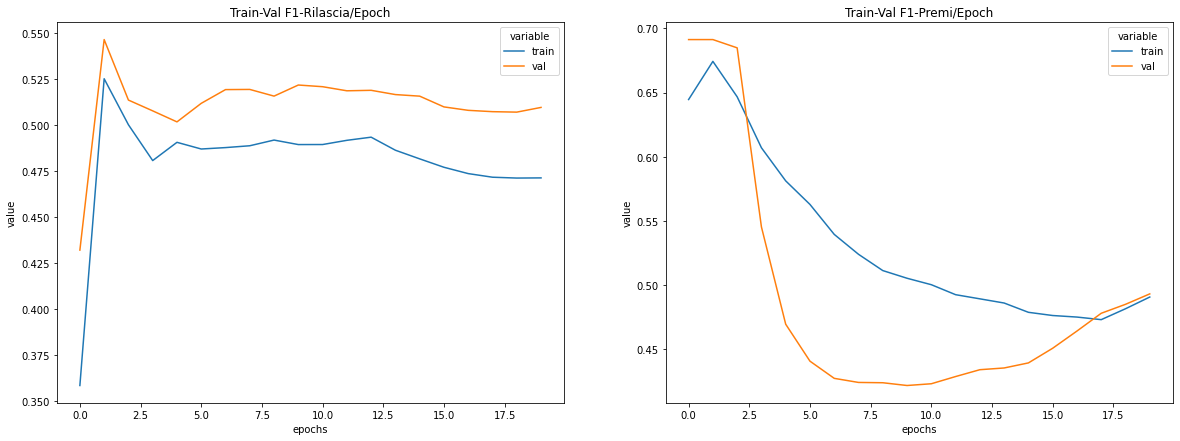

In [56]:
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_f1_Rilascia, x = "epochs", y="value", hue="variable", ax=axes[0]).set_title('Train-Val F1-Rilascia/Epoch')
sns.lineplot(data=train_val_f1_Premi, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val F1-Premi/Epoch')

## Test the model

Al termine dell'addestramento, dobbiamo testare come si è comportato il nostro modello.  Nota che abbiamo usato model.eval() prima di eseguire il nostro codice di test.  Per dire a PyTorch che non vogliamo eseguire la retropropagazione durante l'inferenza, usiamo torch.no_grad(), proprio come abbiamo fatto per il ciclo di convalida sopra.

Iniziamo definendo un elenco che conterrà le nostre previsioni.  Quindi eseguiamo il ciclo dei nostri batch utilizzando test_loader.

In [57]:
from scipy.stats import mode

y_pred_list = []
y_test_label = []
with torch.no_grad():

    model.eval()
    for test in test_dataset:
        X_batch = test.X_data.to(device)
        y_batch = test.y_data.to(device)
        y_test_pred, _ = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        y_test_label.append(y_batch.cpu().numpy())

y_pred_list = [a.tolist() for a in y_pred_list]
#print(len(y_pred_list))
#pred_list = []
#for pred in y_pred_list:
#    for p in pred:
#        pred_list.append(p)
#print(len(pred_list[:-1]))
#print(len(y_test_label))
test_label_real, test_label_pred = [], []
for real, pred in zip(y_test_label, y_pred_list):
    r = mode(real, axis=None)
    test_label_real.append(r[0][0])
    p = mode(pred, axis=None)
    test_label_pred.append(p[0][0])
print(len(test_label_real))
print(len(test_label_pred))

894
894


## Confusion Matrix

Creiamo un dataframe dalla matrice di confusione e lo tracciamo come una mappa di calore utilizzando la libreria Seaborn.

<AxesSubplot:>

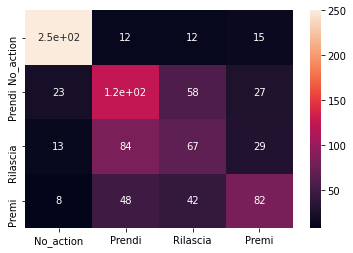

In [58]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(test_label_real, test_label_pred)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [59]:
print(classification_report(test_label_real, test_label_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       289
           1       0.46      0.53      0.50       232
           2       0.37      0.35      0.36       193
           3       0.54      0.46      0.49       180

    accuracy                           0.59       894
   macro avg       0.56      0.55      0.55       894
weighted avg       0.58      0.59      0.58       894



In [60]:
torch.save(model.state_dict(), main_folder + "/mymodel.pt")

In [61]:
nmodel = LSTM(input_size=NUM_FEATURES, output_size=NUM_CLASSES)
nmodel.load_state_dict(torch.load("../data/mymodel.pt"))
print(nmodel)

LSTM(
  (lstm): LSTM(156, 78)
  (regressor): Linear(in_features=78, out_features=4, bias=True)
)


In [62]:
y_pred_list = []
t = torch.from_numpy(np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]).astype(float)).float().to(device)
print(t.shape)

with torch.no_grad():

    model.eval()
    for test in test_dataset:
        print(X_batch[0])
        X_batch = test.X_data.to(device)
        y_test_pred, _ = model(t)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        break
print(len(y_pred_list), y_pred_list)

torch.Size([1, 156])
tensor([ 0.1200, -0.2827,  0.5002,  0.0000,  0.0000,  0.0000,  0.0467, -0.3055,
         0.5442,  0.0000,  0.0000,  0.0000,  0.0558, -0.3136,  0.5779,  0.0000,
         0.0000,  0.0000,  0.0671, -0.3006,  0.5986,  0.0000,  0.0000,  0.0000,
         0.0902, -0.3157,  0.5829,  0.0000,  0.0000,  0.0000,  0.1177, -0.3129,
         0.5675,  0.0000,  0.0000,  0.0000,  0.0633, -0.3050,  0.5331,  0.0000,
         0.0000,  0.0000,  0.0593, -0.3035,  0.5684,  0.0000,  0.0000,  0.0000,
         0.0732, -0.2907,  0.5875,  0.0000,  0.0000,  0.0000,  0.0970, -0.2999,
         0.5785,  0.0000,  0.0000,  0.0000,  0.1260, -0.3010,  0.5668,  0.0000,
         0.0000,  0.0000,  0.0749, -0.3025,  0.5031,  0.0000,  0.0000,  0.0000,
         0.0849, -0.2674,  0.5184,  0.0000,  0.0000,  0.0000,  0.1053, -0.2669,
         0.5236,  0.0000,  0.0000,  0.0000,  0.1229, -0.2745,  0.5286,  0.0000,
         0.0000,  0.0000,  0.1410, -0.2841,  0.5318,  0.0000,  0.0000,  0.0000,
         0.0672, -0